In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import BooleanType
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
spark = SparkSession.builder.appName('I4').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/20 15:44:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 02 - Data Understanding

## 2.2 Describing Data

In [2]:
# Load datasets
df_1 = spark.read.csv('Sleep_health_and_lifestyle_dataset.csv', header=True)
df_2 = spark.read.csv('Sleep_health_and_lifestyle_dataset_2.csv', header=True)

# Explore data
# Initial inspection of data
df_1.show()
df_2.show()


+---------+------+---+--------------------+--------------+----------------+-----------------------+------------+-------------+--------------+----------+-----------+--------------+
|Person ID|Gender|Age|          Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level| BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+---------+------+---+--------------------+--------------+----------------+-----------------------+------------+-------------+--------------+----------+-----------+--------------+
|        1|  Male| 27|   Software Engineer|           6.1|             3.5|                     42|           6|   Overweight|        126/83|        77|       5200|          None|
|        2|  Male| 28|              Doctor|           6.2|               4|                     82|           8|       Normal|        125/80|        75|       8000|          None|
|        3|  Male| 28|              Doctor|           6.2|               5|                     67| 

In [3]:
# Getting number of rows and columns for datasets
print((df_1.count(), len(df_1.columns)))
print((df_2.count(), len(df_2.columns)))

(374, 13)
(374, 5)


In [4]:
# Columns labels
print(df_1.columns)
print(df_2.columns)

['Person ID', 'Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Blood Pressure', 'Heart Rate', 'Daily Steps', 'Sleep Disorder']
['Person ID', 'Bedtime', 'PhoneUse', 'WearsGlasses', 'Religious']


In [5]:
# Description of data
df_1.describe().show(truncate=False, vertical=True)
df_2.describe().show()

-RECORD 0-------------------------------------
 summary                 | count              
 Person ID               | 374                
 Gender                  | 374                
 Age                     | 374                
 Occupation              | 374                
 Sleep Duration          | 374                
 Quality of Sleep        | 374                
 Physical Activity Level | 374                
 Stress Level            | 374                
 BMI Category            | 374                
 Blood Pressure          | 374                
 Heart Rate              | 374                
 Daily Steps             | 374                
 Sleep Disorder          | 374                
-RECORD 1-------------------------------------
 summary                 | mean               
 Person ID               | 187.5              
 Gender                  | null               
 Age                     | 42.18449197860963  
 Occupation              | null               
 Sleep Durati

In [6]:
# Let's import in the relevant types.

from pyspark.sql.types import (StructField,StringType,IntegerType,FloatType,StructType)

# Correct structure for now
data_schema = [StructField('PersonID',FloatType(),True),
              StructField('Gender',StringType(),True),
              StructField('Age',FloatType(),True),
              StructField('Occupation',StringType(),True),
              StructField('Sleep Duration',FloatType(),True),
              StructField('Quality of Sleep',FloatType(),True),
              StructField('Physical Activity Level',FloatType(),True),
              StructField('Stress Level',FloatType(),True),
              StructField('BMI Category',StringType(),True),
              StructField('Blood Pressure',StringType(),True),
              StructField('Heart Rate',FloatType(),True),
              StructField('Daily Steps',FloatType(),True),
              StructField('Sleep Disorder',StringType(),True),
              ]

final_struct = StructType(fields=data_schema)
# Apply schema to df_1 with new variable types
df_1 = spark.read.csv('Sleep_health_and_lifestyle_dataset.csv', schema=final_struct)

df_1.printSchema()


root
 |-- PersonID: float (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: float (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Sleep Duration: float (nullable = true)
 |-- Quality of Sleep: float (nullable = true)
 |-- Physical Activity Level: float (nullable = true)
 |-- Stress Level: float (nullable = true)
 |-- BMI Category: string (nullable = true)
 |-- Blood Pressure: string (nullable = true)
 |-- Heart Rate: float (nullable = true)
 |-- Daily Steps: float (nullable = true)
 |-- Sleep Disorder: string (nullable = true)



In [7]:
# Only looking at age.show()
df_1.select('Age').describe().show()


+-------+-----------------+
|summary|              Age|
+-------+-----------------+
|  count|              374|
|   mean|42.18449197860963|
| stddev|8.673133465547242|
|    min|             27.0|
|    max|             59.0|
+-------+-----------------+



In [8]:
# Looking at summary of Physical Activity Level and Daily Steps
df_1.select('Physical Activity Level').describe().show()
df_1.dropna(subset=['Daily Steps']).select('Daily Steps').describe().show()

+-------+-----------------------+
|summary|Physical Activity Level|
+-------+-----------------------+
|  count|                    374|
|   mean|     47.094652406512736|
| stddev|     25.761316745976746|
|    min|                    0.3|
|    max|                  210.0|
+-------+-----------------------+

+-------+------------------+
|summary|       Daily Steps|
+-------+------------------+
|  count|               368|
|   mean| 5839.942934782609|
| stddev|1769.0999572833714|
|    min|            2000.0|
|    max|           14000.0|
+-------+------------------+



In [9]:
# Number of unique values
print (df_1.select('Physical Activity Level').distinct().count())
print (df_1.select('Daily Steps').distinct().count())

68
63


In [10]:
# Count of values for each occupation
df_1.groupBy('Occupation').count().show()

+--------------------+-----+
|          Occupation|count|
+--------------------+-----+
|           Scientist|    4|
|          Occupation|    1|
|               Nurse|   73|
|         Salesperson|   32|
|              Lawyer|   47|
|             Teacher|   40|
|Sales Representative|    2|
|              Doctor|   71|
|            Engineer|   63|
|          Accountant|   37|
|             Manager|    1|
|   Software Engineer|    4|
+--------------------+-----+



In [11]:
# Distinct values for Bedtime
print (df_2.select('Bedtime').distinct().count())


42


## 2.3 Data Exploration

+--------------+-----+
|Sleep Disorder|count|
+--------------+-----+
|          None|  216|
|   Sleep Apnea|   78|
|      Insomnia|   80|
|Sleep Disorder|    1|
+--------------+-----+



Text(0, 0.5, 'Count')

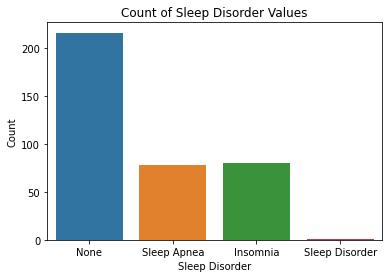

In [12]:
# Count of sleep disorder values
sleep_disorder_dist = df_1.groupBy("Sleep Disorder").agg(count("Sleep Disorder").alias("count"))
sleep_disorder_dist.show()
# Convert Spark df to a Pandas df
sleep_disorder_dist_pd = sleep_disorder_dist.toPandas()
# Create barplot
sns.barplot(x="Sleep Disorder", y="count", data=sleep_disorder_dist_pd)

# Add titles and labels
plt.title("Count of Sleep Disorder Values")
plt.xlabel("Sleep Disorder")
plt.ylabel("Count")


+-------------+-----+
| BMI Category|count|
+-------------+-----+
|Normal Weight|   21|
|   Overweight|  151|
|        Obese|   10|
| BMI Category|    1|
|       Normal|  192|
+-------------+-----+



Text(0, 0.5, 'Count')

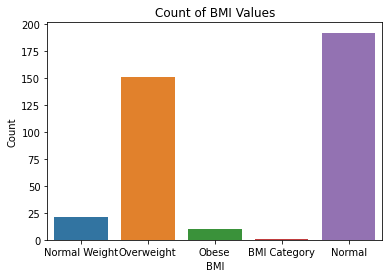

In [13]:
# Count of BMI values
bmi_dist = df_1.groupBy("BMI Category").agg(count("BMI Category").alias("count"))
bmi_dist.show()
# Convert Spark df to a Pandas df
bmi_dist_pd = bmi_dist.toPandas()
# Create barplot
sns.barplot(x="BMI Category", y="count", data=bmi_dist_pd)

# Add titles and labels
plt.title("Count of BMI Values")
plt.xlabel("BMI")
plt.ylabel("Count")

+--------------------+-----+
|          Occupation|count|
+--------------------+-----+
|           Scientist|    4|
|          Occupation|    1|
|               Nurse|   73|
|         Salesperson|   32|
|              Lawyer|   47|
|             Teacher|   40|
|Sales Representative|    2|
|              Doctor|   71|
|            Engineer|   63|
|          Accountant|   37|
|             Manager|    1|
|   Software Engineer|    4|
+--------------------+-----+

+--------------------+-----+-------------------+
|          Occupation|count|         percentage|
+--------------------+-----+-------------------+
|           Scientist|    4| 1.0666666666666667|
|          Occupation|    1|0.26666666666666666|
|               Nurse|   73| 19.466666666666665|
|         Salesperson|   32|  8.533333333333333|
|              Lawyer|   47| 12.533333333333333|
|             Teacher|   40| 10.666666666666668|
|Sales Representative|    2| 0.5333333333333333|
|              Doctor|   71| 18.9333333333333

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Scientist'),
  Text(1, 0, 'Occupation'),
  Text(2, 0, 'Nurse'),
  Text(3, 0, 'Salesperson'),
  Text(4, 0, 'Lawyer'),
  Text(5, 0, 'Teacher'),
  Text(6, 0, 'Sales Representative'),
  Text(7, 0, 'Doctor'),
  Text(8, 0, 'Engineer'),
  Text(9, 0, 'Accountant'),
  Text(10, 0, 'Manager'),
  Text(11, 0, 'Software Engineer')])

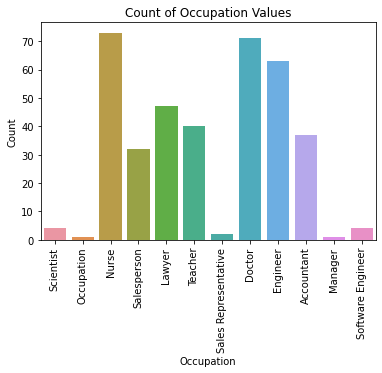

In [14]:
# Count of Occupation values
occ_dist = df_1.groupBy("Occupation").agg(count("Occupation").alias("count"))
occ_dist.show()
# Convert to percentage
occ_perc_dist = occ_dist.withColumn('percentage', (col('count') / df_1.count()) * 100)
occ_perc_dist.show()

# Convert Spark df to a Pandas df
occ_dist_pd = occ_dist.toPandas()
# Create barplot
sns.barplot(x="Occupation", y="count", data=occ_dist_pd)

# Add titles and labels
plt.title("Count of Occupation Values")
plt.xlabel("Occupation")
plt.ylabel("Count")
# Rotate them to vertical to make space for value labels
plt.xticks(rotation=90)

+--------------------+---------------------+
|          Occupation|Mean Quality of Sleep|
+--------------------+---------------------+
|           Scientist|                 2.75|
|          Occupation|                 null|
|               Nurse|     5.86986301369863|
|         Salesperson|              5.46875|
|              Lawyer|    6.382978723404255|
|             Teacher|               6.2125|
|Sales Representative|                  2.0|
|              Doctor|    6.112676056338028|
|            Engineer|    7.158730158730159|
|          Accountant|    7.202702702702703|
|             Manager|                  7.0|
|   Software Engineer|                5.625|
+--------------------+---------------------+



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Scientist'),
  Text(1, 0, 'Occupation'),
  Text(2, 0, 'Nurse'),
  Text(3, 0, 'Salesperson'),
  Text(4, 0, 'Lawyer'),
  Text(5, 0, 'Teacher'),
  Text(6, 0, 'Sales Representative'),
  Text(7, 0, 'Doctor'),
  Text(8, 0, 'Engineer'),
  Text(9, 0, 'Accountant'),
  Text(10, 0, 'Manager'),
  Text(11, 0, 'Software Engineer')])

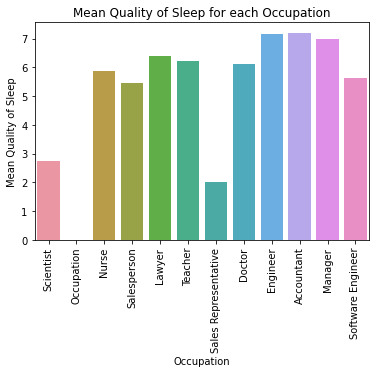

In [15]:
# Group by occupation and plot against mean of Quality of Sleep
occ_mean = df_1.groupBy("Occupation").agg(mean("Quality of Sleep").alias("Mean Quality of Sleep"))
occ_mean.show()

# Convert Spark df to a Pandas df
occ_mean_pd = occ_mean.toPandas()
# Create barplot
sns.barplot(x="Occupation", y="Mean Quality of Sleep", data=occ_mean_pd)

# Add titles and labels
plt.title("Mean Quality of Sleep for each Occupation")
plt.xlabel("Occupation")
plt.ylabel("Mean Quality of Sleep")
# Rotate them to vertical to make space for value labels
plt.xticks(rotation=90)

+-------------------------------+-----+
|Rounded Physical Activity Level|count|
+-------------------------------+-----+
|                          160.0|    1|
|                           70.0|   18|
|                            0.0|    3|
|                           null|    0|
|                           80.0|   22|
|                          120.0|    5|
|                          210.0|    1|
|                           50.0|   43|
|                          130.0|    1|
|                           60.0|   65|
|                           10.0|    2|
|                           40.0|   46|
|                           30.0|  100|
|                          100.0|    1|
|                           20.0|   42|
|                          150.0|    1|
|                           90.0|   22|
|                          110.0|    1|
+-------------------------------+-----+



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, '0.0'),
  Text(1, 0, '10.0'),
  Text(2, 0, '20.0'),
  Text(3, 0, '30.0'),
  Text(4, 0, '40.0'),
  Text(5, 0, '50.0'),
  Text(6, 0, '60.0'),
  Text(7, 0, '70.0'),
  Text(8, 0, '80.0'),
  Text(9, 0, '90.0'),
  Text(10, 0, '100.0'),
  Text(11, 0, '110.0'),
  Text(12, 0, '120.0'),
  Text(13, 0, '130.0'),
  Text(14, 0, '150.0'),
  Text(15, 0, '160.0'),
  Text(16, 0, '210.0')])

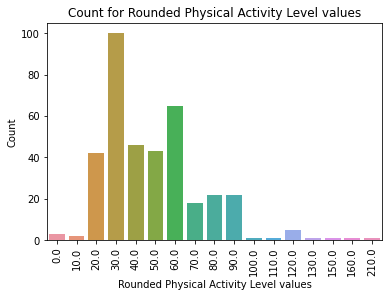

In [16]:
# Round of Physical Activity Level to allow column labels to be seen as there are too many distinct values
rounded_pal = df_1.withColumn('Rounded Physical Activity Level', round(df_1['Physical Activity Level'] / 10) * 10)
# Group by 'Rounded Physical Activity Level' and count
rounded_pal_dist = rounded_pal.groupBy('Rounded Physical Activity Level').agg(count('Rounded Physical Activity Level').alias('count'))
rounded_pal_dist.show()

# Convert Spark df to a Pandas df
rounded_pal_pd = rounded_pal_dist.toPandas()
# Create barplot
sns.barplot(x="Rounded Physical Activity Level", y="count", data=rounded_pal_pd)

# Add titles and labels
plt.title("Count for Rounded Physical Activity Level values")
plt.xlabel("Rounded Physical Activity Level values")
plt.ylabel("Count")
# Rotate them to vertical to make space for value labels
plt.xticks(rotation=90)

<AxesSubplot:xlabel='Physical Activity Level', ylabel='Density'>

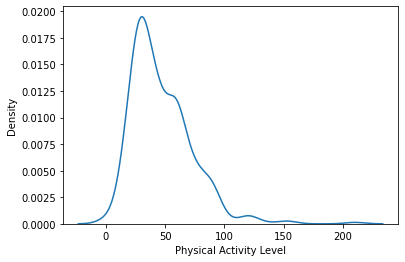

In [17]:
# Select Physical Activity Level and convert to pandas to plot
pal_df = df_1.select('Physical Activity Level').toPandas()
sns.kdeplot(data=pal_df, x='Physical Activity Level')


Text(16.299999999999997, 0.5, 'Quality of Sleep')

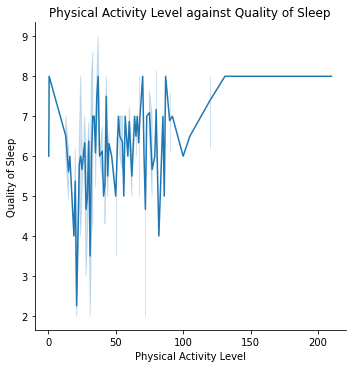

In [18]:
qol_pal_df = df_1.select('Quality of Sleep', 'Physical Activity Level').toPandas()
# Create barplot
sns.relplot(x="Physical Activity Level", y="Quality of Sleep", data=qol_pal_df, kind="line")

# Add titles and labels
plt.title("Physical Activity Level against Quality of Sleep")
plt.xlabel("Physical Activity Level")
plt.ylabel("Quality of Sleep")


-0.3313537991242806

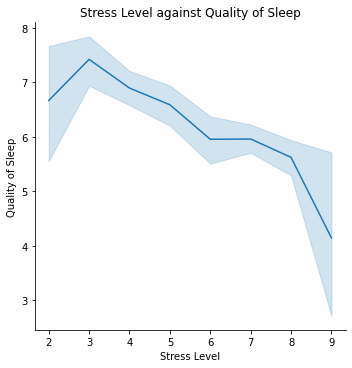

In [19]:
# Selecting the features for analysis
qol_stress_df = df_1.select('Quality of Sleep', 'Stress Level').toPandas()
# Create barplot
sns.relplot(x="Stress Level", y="Quality of Sleep", data=qol_stress_df, kind="line")

# Add titles and labels
plt.title("Stress Level against Quality of Sleep")
plt.xlabel("Stress Level")
plt.ylabel("Quality of Sleep")

# Finding the correlation
df_1.corr('Quality of Sleep', 'Stress Level')

+------------+-----+
|Stress Level|count|
+------------+-----+
|         9.0|    7|
|         5.0|   68|
|        null|    0|
|         7.0|   75|
|         2.0|    9|
|         3.0|   32|
|         6.0|   56|
|         8.0|   65|
|         4.0|   62|
+------------+-----+



(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, '2.0'),
  Text(1, 0, '3.0'),
  Text(2, 0, '4.0'),
  Text(3, 0, '5.0'),
  Text(4, 0, '6.0'),
  Text(5, 0, '7.0'),
  Text(6, 0, '8.0'),
  Text(7, 0, '9.0')])

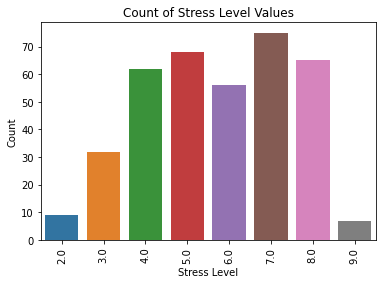

In [20]:
# Looking at distribution of stress level
stress_dist = df_1.groupBy("Stress Level").agg(count("Stress Level").alias("count"))
stress_dist.show()

# Convert Spark df to a Pandas df
stress_dist_pd = stress_dist.toPandas()
# Create barplot
sns.barplot(x="Stress Level", y="count", data=stress_dist_pd)

# Add titles and labels
plt.title("Count of Stress Level Values")
plt.xlabel("Stress Level")
plt.ylabel("Count")
# Rotate them to vertical to make space for value labels
plt.xticks(rotation=90)

+--------------------+---------------------+
|          Occupation|Mean Quality of Sleep|
+--------------------+---------------------+
|           Scientist|                 2.75|
|          Occupation|                 null|
|               Nurse|     5.86986301369863|
|         Salesperson|              5.46875|
|              Lawyer|    6.382978723404255|
|             Teacher|               6.2125|
|Sales Representative|                  2.0|
|              Doctor|    6.112676056338028|
|            Engineer|    7.158730158730159|
|          Accountant|    7.202702702702703|
|             Manager|                  7.0|
|   Software Engineer|                5.625|
+--------------------+---------------------+



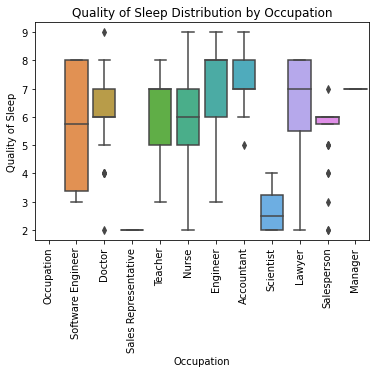

In [21]:
# Box plot of Quality of Sleep for each occupation
sns.boxplot(x='Occupation', y='Quality of Sleep', data=df_1.toPandas())
# Add titles and labels
plt.title('Quality of Sleep Distribution by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Quality of Sleep')
# Rotate them to vertical to make space for value labels
plt.xticks(rotation=90)

# Mean for each occupation
df_1.groupBy('Occupation').agg(mean('Quality of Sleep').alias('Mean Quality of Sleep')).show()


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'BMI Category'),
  Text(1, 0, 'Overweight'),
  Text(2, 0, 'Normal'),
  Text(3, 0, 'Obese'),
  Text(4, 0, 'Normal Weight')])

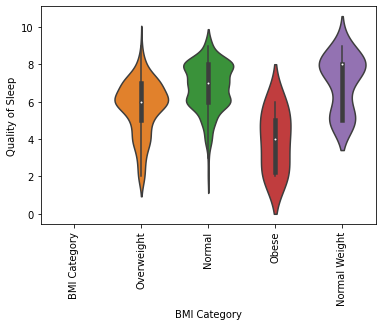

In [22]:
# Violin plot of Quality of Sleep for each BMI
sns.violinplot(x='BMI Category', y='Quality of Sleep', data=df_1.toPandas())
# Rotate them to vertical to make space for value labels
plt.xticks(rotation=90)

42
+-------+-----+
|Bedtime|count|
+-------+-----+
|   0:40|    4|
|   2:40|    1|
|   1:50|    2|
|   3:10|    1|
|   1:45|    2|
|   2:50|    1|
|  21:45|    1|
|   2:45|    1|
|  22:15|    1|
|  21:00|    4|
|   0:20|    2|
|   1:20|    4|
|  11:30|    2|
|  22:40|    3|
|   4:30|    1|
|   2:00|   17|
|  23:50|    5|
|   1:10|    2|
|  23:30|   42|
|  22:20|    1|
+-------+-----+
only showing top 20 rows



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 [Text(0, 0, '0:40'),
  Text(1, 0, '2:40'),
  Text(2, 0, '1:50'),
  Text(3, 0, '3:10'),
  Text(4, 0, '1:45'),
  Text(5, 0, '2:50'),
  Text(6, 0, '21:45'),
  Text(7, 0, '2:45'),
  Text(8, 0, '22:15'),
  Text(9, 0, '21:00'),
  Text(10, 0, '0:20'),
  Text(11, 0, '1:20'),
  Text(12, 0, '11:30'),
  Text(13, 0, '22:40'),
  Text(14, 0, '4:30'),
  Text(15, 0, '2:00'),
  Text(16, 0, '23:50'),
  Text(17, 0, '1:10'),
  Text(18, 0, '23:30'),
  Text(19, 0, '22:20'),
  Text(20, 0, '21:30'),
  Text(21, 0, '0:50'),
  Text(22, 0, '2:20'),
  Text(23, 0, '1:15'),
  Text(24, 0, '23:10'),
  Text(25, 0, '23:20'),
  Text(26, 0, '3:00'),
  Text(27, 0, '22:00'),
  Text(28, 0, '1:40'),
  Text(29, 0, '23:15'),
  Text(30, 0, '2:15'),
  Text(31, 0, '22:30'),
  Text(32, 0, '1:30'),
  Text(33, 0, '23:40'),
  Text(34, 0, '22:5

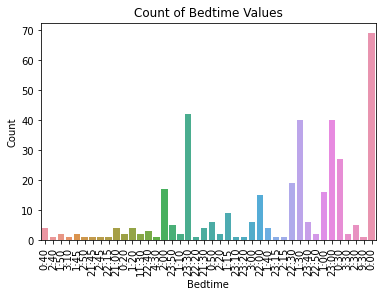

In [23]:
# Looking at distribution of bedtime
bt_dist = df_2.groupBy("Bedtime").agg(count("Bedtime").alias("count"))
# Number of unique values
print(bt_dist.count())
bt_dist.show()

# Convert Spark df to a Pandas df
bt_dist_pd = bt_dist.toPandas()
# Create barplot
sns.barplot(x="Bedtime", y="count", data=bt_dist_pd)

# Add titles and labels
plt.title("Count of Bedtime Values")
plt.xlabel("Bedtime")
plt.ylabel("Count")
# Rotate them to vertical to make space for value labels
plt.xticks(rotation=90)

## 2.4 Verifying Data Quality 

In [24]:
# Check for null values in each column
df_1.select([count(when(isnan(c), c)).alias(c) for c in df_1.columns]).show(truncate=False, vertical=True)
df_2.select([count(when(isnan(c), c)).alias(c) for c in df_2.columns]).show(truncate=False, vertical=True)


-RECORD 0----------------------
 PersonID                | 0   
 Gender                  | 0   
 Age                     | 0   
 Occupation              | 0   
 Sleep Duration          | 0   
 Quality of Sleep        | 0   
 Physical Activity Level | 0   
 Stress Level            | 0   
 BMI Category            | 0   
 Blood Pressure          | 0   
 Heart Rate              | 0   
 Daily Steps             | 6   
 Sleep Disorder          | 0   

-RECORD 0-----------
 Person ID    | 0   
 Bedtime      | 0   
 PhoneUse     | 0   
 WearsGlasses | 0   
 Religious    | 0   



+------+-----+
|Gender|count|
+------+-----+
|     F|    2|
|Female|  183|
|     M|    3|
|  Male|  186|
|Gender|    1|
+------+-----+



Text(0, 0.5, 'Count')

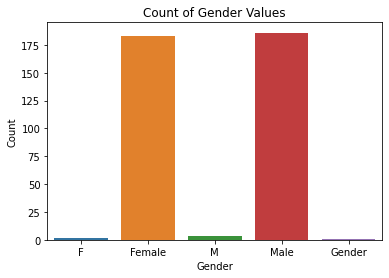

In [25]:
# Looking at distribution of genders
gender_dist = df_1.groupBy("Gender").agg(count("Gender").alias("count"))
gender_dist.show()

# Convert Spark df to a Pandas df
gender_dist_pd = gender_dist.toPandas()
# Create barplot
sns.barplot(x="Gender", y="count", data=gender_dist_pd)

# Add titles and labels
plt.title("Count of Gender Values")
plt.xlabel("Gender")
plt.ylabel("Count")


In [26]:
# Get values with decimal points (not .0) in Quality of Sleep
df_1.filter(col('Quality of Sleep') % 1 != 0).show()

+--------+------+----+-----------------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|PersonID|Gender| Age|       Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+--------+------+----+-----------------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|     1.0|  Male|27.0|Software Engineer|           6.1|             3.5|                   42.0|         6.0|  Overweight|        126/83|      77.0|     5200.0|          None|
|    91.0|  Male|35.0|         Engineer|           7.3|             7.5|                   60.0|         4.0|      Normal|        125/80|      65.0|     5000.0|          None|
|   134.0|Female|38.0|       Accountant|           7.1|             7.5|                   60.0|         4.0|      Norma

+----------+-----+
|Heart Rate|count|
+----------+-----+
|      82.0|    1|
|      86.0|    2|
|      null|    0|
|      67.0|    2|
|      70.0|   75|
|      72.0|   69|
|      65.0|   67|
|      85.0|    3|
|      68.0|   94|
|      77.0|    2|
|      83.0|    2|
|      78.0|    5|
|      80.0|    3|
|      76.0|    2|
|      88.0|    1|
|      69.0|    2|
|      45.0|    1|
|      81.0|    2|
|      84.0|    1|
|      73.0|    2|
+----------+-----+
only showing top 20 rows



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 [Text(0, 0, '45.0'),
  Text(1, 0, '65.0'),
  Text(2, 0, '67.0'),
  Text(3, 0, '68.0'),
  Text(4, 0, '69.0'),
  Text(5, 0, '70.0'),
  Text(6, 0, '72.0'),
  Text(7, 0, '73.0'),
  Text(8, 0, '74.0'),
  Text(9, 0, '75.0'),
  Text(10, 0, '76.0'),
  Text(11, 0, '77.0'),
  Text(12, 0, '78.0'),
  Text(13, 0, '80.0'),
  Text(14, 0, '81.0'),
  Text(15, 0, '82.0'),
  Text(16, 0, '83.0'),
  Text(17, 0, '84.0'),
  Text(18, 0, '85.0'),
  Text(19, 0, '86.0'),
  Text(20, 0, '88.0')])

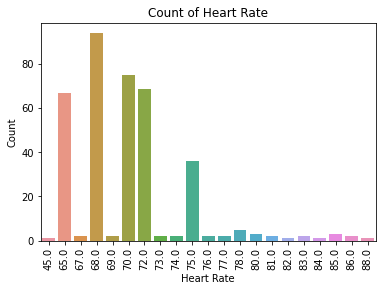

In [27]:
# Looking at distribution of heart rate
heart_rate_dist = df_1.groupBy("Heart Rate").agg(count("Heart Rate").alias("count"))
heart_rate_dist.show()

# Convert Spark df to a Pandas df
heart_rate_dist_pd = heart_rate_dist.toPandas()
# Create barplot
sns.barplot(x="Heart Rate", y="count", data=heart_rate_dist_pd)

# Add titles and labels
plt.title("Count of Heart Rate")
plt.xlabel("Heart Rate")
plt.ylabel("Count")
# Rotate them to vertical to make space for value labels
plt.xticks(rotation=90)

In [28]:
# Calculate mean and standard deviation of Heart Rate
mean_hr = df_1.select(mean(col("Heart Rate")).alias("mean_hr")).collect()[0]["mean_hr"]
sd_hr = df_1.select(stddev(col("Heart Rate")).alias("sd_hr")).collect()[0]["sd_hr"]

# Calculate z-score for Heart Rate
df_with_z_score = df_1.withColumn("z_score", abs((col("Heart Rate") - mean_hr) / sd_hr))

# Identify outliers as Heart Rate with a z-score greater than 3
z_threshold = 3
outliers = df_with_z_score.filter(col("z_score") > z_threshold)
outliers.show()

+--------+------+----+--------------------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+------------------+
|PersonID|Gender| Age|          Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|           z_score|
+--------+------+----+--------------------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+------------------+
|     4.0|  Male|28.0|Sales Representative|           5.9|             2.0|                   33.0|         8.0|       Obese|        140/90|      85.0|     2500.0|   Sleep Apnea|3.4037400672480294|
|     5.0|  Male|28.0|Sales Representative|           5.9|             2.0|                   31.0|         6.0|       Obese|        140/90|      85.0|     3000.0|   Sleep Apnea|3.4037400672480294|
|     6.0|

## 3.2 Cleaning Data

In [29]:
# Get values with NaN in Daily Steps
df_1.filter(col('Daily Steps') == 'NaN').show()

+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|PersonID|Gender| Age|Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|    21.0|  Male|30.0|    Doctor|           5.9|             7.0|                   60.0|         7.0|      Normal|        120/80|      70.0|        NaN|          None|
|    59.0|  Male|32.0|    Doctor|           6.0|             6.0|                   30.0|         8.0|      Normal|        125/80|      72.0|        NaN|          None|
|    64.0|  Male|32.0|    Doctor|           6.6|             6.0|                   55.0|         8.0|      Normal|        125/80|      72.0|        NaN|  

In [30]:
# Mean Physical Activity Level
mean_pal = df_1.select(mean(col("Physical Activity Level")).alias("mean_pal")).collect()[0]["mean_pal"]
print (mean_pal)

47.094652406512736


In [31]:
# Train linear model 
# Filter out rows where Daily Steps are not NaN to be used for training
df_filtered = df_1.filter(~isnan(col("Daily Steps")) & col("Daily Steps").isNotNull() & col("Physical Activity Level").isNotNull())

# Assemble feature vector
assembler = VectorAssembler(inputCols=["Physical Activity Level"], outputCol="feature")
df_filtered = assembler.transform(df_filtered)

# Train Linear Regression model
missing_linear_ds = LinearRegression(featuresCol="feature", labelCol="Daily Steps")
missing_linear_ds_model = missing_linear_ds.fit(df_filtered)

# Prepare DataFrame for prediction where Daily Steps is NaN to be used for predictions
df_missing_ds = df_1.filter(isnan(col("Daily Steps")) & col("Daily Steps").isNotNull() & col("Physical Activity Level").isNotNull())
df_missing_ds = assembler.transform(df_missing_ds)
df_missing_ds.show()

# Predict missing Daily Steps values into a prediction column and round them off to nearest integer
predictions = missing_linear_ds_model.transform(df_missing_ds)
predictions = predictions.withColumn("prediction", round(col("prediction")))
predictions.show()

# Join predictions with original DataFrame based on unique Participant ID
df_1_imp = df_1.join(predictions.select("PersonID", "prediction"), on="PersonID", how="left_outer")

# Replace Daily Steps values with predictions if there is any (should only be 6), otherwise keep original values
df_1_imp = df_1_imp.withColumn("Daily Steps", coalesce(col("prediction"), col("Daily Steps")))

# Find replaced values based on prediction column that is not null (hence predicted)
df_1_imp.filter(col("prediction").isNotNull()).show()

# Drop the prediction column as it's no longer needed
df_1_imp = df_1_imp.drop("prediction")

24/05/20 15:45:14 WARN Instrumentation: [39c6f0b3] regParam is zero, which might cause numerical instability and overfitting.
24/05/20 15:45:15 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/20 15:45:15 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
24/05/20 15:45:15 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+-------+
|PersonID|Gender| Age|Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|feature|
+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+-------+
|    21.0|  Male|30.0|    Doctor|           5.9|             7.0|                   60.0|         7.0|      Normal|        120/80|      70.0|        NaN|          None| [60.0]|
|    59.0|  Male|32.0|    Doctor|           6.0|             6.0|                   30.0|         8.0|      Normal|        125/80|      72.0|        NaN|          None| [30.0]|
|    64.0|  Male|32.0|    Doctor|           6.6|             6.0|                   55.0|         8.0|      Normal|

In [32]:
# Look at first 25 rows
df_1_imp.show(25)

+--------+------+----+--------------------+--------------+----------------+-----------------------+------------+-------------+--------------+----------+-----------+--------------+
|PersonID|Gender| Age|          Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level| BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+--------+------+----+--------------------+--------------+----------------+-----------------------+------------+-------------+--------------+----------+-----------+--------------+
|    null|Gender|null|          Occupation|          null|            null|                   null|        null| BMI Category|Blood Pressure|      null|       null|Sleep Disorder|
|     1.0|  Male|27.0|   Software Engineer|           6.1|             3.5|                   42.0|         6.0|   Overweight|        126/83|      77.0|     5200.0|          None|
|     2.0|  Male|28.0|              Doctor|           6.2|             4.0|                   82.0| 

In [33]:
# Change Heart Rate value of 45 to 83
df_1_imp.filter(col("Heart Rate") == 45).show()
df_1_imp = df_1_imp.withColumn("Heart Rate", when(col("Heart Rate") == 45, 83).otherwise(col("Heart Rate")))
df_1_imp.filter(col("PersonID") == 146).show()


+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|PersonID|Gender| Age|Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|   146.0|Female|38.0|    Lawyer|           4.9|             2.0|                   25.0|         8.0|       Obese|        135/88|      45.0|     3300.0|   Sleep Apnea|
+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+

+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+-

In [34]:
# Locate all Physical Activity Level values lower than 1
low_pal = df_1_imp.filter(col("Physical Activity Level") < 1)
low_pal.show()

+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|PersonID|Gender| Age|Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|    47.0|  Male|31.0|    Doctor|           6.7|             7.0|                    0.5|         8.0|      Normal|        120/80|      70.0|     5000.0|          None|
|   112.0|  Male|37.0|    Lawyer|           7.4|             8.0|                    0.6|         8.0|      Normal|        130/85|      68.0|     2800.0|          None|
|   357.0|Female|58.0|     Nurse|           7.3|             6.0|                    0.3|         7.0|  Overweight|        140/95|      68.0|     5900.0|  

In [35]:
# Change Physical Activity Level from 0.5 to 60
df_1_imp.filter(col("Physical Activity Level") == 0.5).show()
df_1_imp = df_1_imp.withColumn("Physical Activity Level", when(col("Physical Activity Level") == 0.5, 60).otherwise(col("Physical Activity Level")))
df_1_imp.filter(col("PersonID") == 47).show()


+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|PersonID|Gender| Age|Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|    47.0|  Male|31.0|    Doctor|           6.7|             7.0|                    0.5|         8.0|      Normal|        120/80|      70.0|     5000.0|          None|
+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+

+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+-

In [36]:
# Locate all Physical Activity Level values lower than 1
low_pal = df_1_imp.filter(col("Physical Activity Level") < 1)
low_pal_values = low_pal.select("PersonID", "Physical Activity Level").collect()
print (low_pal_values[0][1])
print (low_pal_values[1][1])
# Show the rows where Physical Activity Level is lower than 1
low_pal.show()

0.6000000238418579
0.30000001192092896
+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|PersonID|Gender| Age|Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|   112.0|  Male|37.0|    Lawyer|           7.4|             8.0|                    0.6|         8.0|      Normal|        130/85|      68.0|     2800.0|          None|
|   357.0|Female|58.0|     Nurse|           7.3|             6.0|                    0.3|         7.0|  Overweight|        140/95|      68.0|     5900.0|   Sleep Apnea|
+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+-

In [37]:
# Replace the rest of the outliers less than 1
df_1_imp = df_1_imp.withColumn("Physical Activity Level", when(col("Physical Activity Level") == 0.6000000238418579, 60).otherwise(col("Physical Activity Level")))
df_1_imp = df_1_imp.withColumn("Physical Activity Level", when(col("Physical Activity Level") == 0.30000001192092896, 30).otherwise(col("Physical Activity Level")))
df_1_imp.filter((col("PersonID") == 112) | (col("PersonID") == 357)).show()


+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|PersonID|Gender| Age|Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|   112.0|  Male|37.0|    Lawyer|           7.4|             8.0|                   60.0|         8.0|      Normal|        130/85|      68.0|     2800.0|          None|
|   357.0|Female|58.0|     Nurse|           7.3|             6.0|                   30.0|         7.0|  Overweight|        140/95|      68.0|     5900.0|   Sleep Apnea|
+--------+------+----+----------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--

In [38]:
# Get values with decimal points (not .0) in Quality of Sleep
float_qol_df = df_1_imp.filter(col('Quality of Sleep') % 1 != 0)
float_qol_df.show()
# Get all PersonIDs of those with float values
float_qol_ID = [row['PersonID'] for row in float_qol_df.select('PersonID').collect()]
# Round values to closest whole number
df_1_imp = df_1_imp.withColumn("Quality of Sleep", round(col("Quality of Sleep"), 0))
# Filter out those that were in float_qol_ID
df_1_imp.filter(col("PersonID").isin(float_qol_ID)).show()

+--------+------+----+-----------------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|PersonID|Gender| Age|       Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+--------+------+----+-----------------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|     1.0|  Male|27.0|Software Engineer|           6.1|             3.5|                   42.0|         6.0|  Overweight|        126/83|      77.0|     5200.0|          None|
|    91.0|  Male|35.0|         Engineer|           7.3|             7.5|                   60.0|         4.0|      Normal|        125/80|      65.0|     5000.0|          None|
|   134.0|Female|38.0|       Accountant|           7.1|             7.5|                   60.0|         4.0|      Norma

In [39]:
# Initial schema
df_1_imp.printSchema()
new_data_types = {
    "PersonID": IntegerType(),
    "Gender": StringType(),
    "Age": IntegerType(),
    "Occupation": StringType(),
    "Sleep Duration": FloatType(),
    "Quality of Sleep": IntegerType(),
    "Physical Activity Level": IntegerType(),
    "Stress Level": IntegerType(),
    "BMI Category": StringType(),
    "Blood Pressure": StringType(),
    "Heart Rate": IntegerType(),
    "Daily Steps": IntegerType(),
    "Sleep Disorder": StringType()
}

# Apply the data types to each column
for col_name, target_type in new_data_types.items():
    df_1_imp = df_1_imp.withColumn(col_name, df_1_imp[col_name].cast(target_type))
    
# New Schema
df_1_imp.printSchema()

root
 |-- PersonID: float (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: float (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Sleep Duration: float (nullable = true)
 |-- Quality of Sleep: float (nullable = true)
 |-- Physical Activity Level: float (nullable = true)
 |-- Stress Level: float (nullable = true)
 |-- BMI Category: string (nullable = true)
 |-- Blood Pressure: string (nullable = true)
 |-- Heart Rate: float (nullable = true)
 |-- Daily Steps: double (nullable = true)
 |-- Sleep Disorder: string (nullable = true)

root
 |-- PersonID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Sleep Duration: float (nullable = true)
 |-- Quality of Sleep: integer (nullable = true)
 |-- Physical Activity Level: integer (nullable = true)
 |-- Stress Level: integer (nullable = true)
 |-- BMI Category: string (nullable = true)
 |-- Blood Pressure: string (nu

## 3.3 Construct New Data

Text(0, 0.5, 'Count')

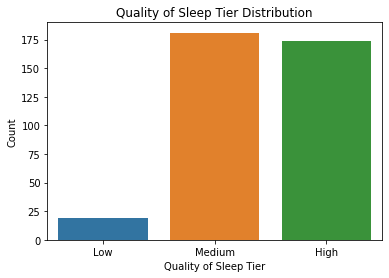

In [40]:
# Construct new column according to ranges
df_1_imp = df_1_imp.withColumn(
    "Quality_of_Sleep_Tier",
    when((col("Quality of Sleep") >= 1) & (col("Quality of Sleep") <= 3), "Low")
    .when((col("Quality of Sleep") >= 4) & (col("Quality of Sleep") <= 6), "Medium")
    .when((col("Quality of Sleep") >= 7) & (col("Quality of Sleep") <= 9), "High")
)
sns.countplot(data=df_1_imp.toPandas(), x='Quality_of_Sleep_Tier', order=["Low", "Medium", "High"])
# Add titles and labels
plt.title("Quality of Sleep Tier Distribution")
plt.xlabel("Quality of Sleep Tier")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

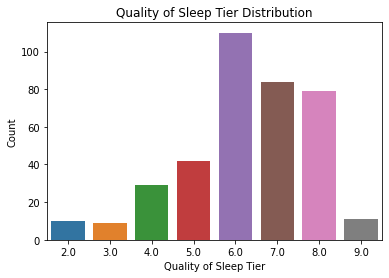

In [41]:
# Count plot of Quality of Sleep values
sns.countplot(data=df_1_imp.toPandas(), x='Quality of Sleep')
# Add titles and labels
plt.title("Quality of Sleep Tier Distribution")
plt.xlabel("Quality of Sleep Tier")
plt.ylabel("Count")

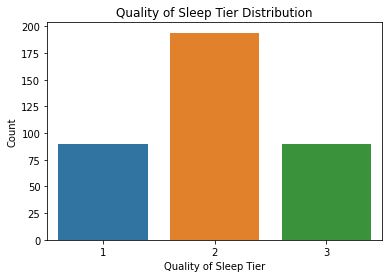

In [42]:
# Construct new column according to new ranges
df_1_imp = df_1_imp.withColumn(
    "Quality_of_Sleep_Tier",
    when((col("Quality of Sleep") <= 5), 1)
    .when((col("Quality of Sleep") >= 6) & (col("Quality of Sleep") <= 7), 2)
    .when((col("Quality of Sleep") >= 8), 3)
)
sns.countplot(data=df_1_imp.toPandas(), x='Quality_of_Sleep_Tier', order=[1, 2, 3])
# Add titles and labels
plt.title("Quality of Sleep Tier Distribution")
plt.xlabel("Quality of Sleep Tier")
plt.ylabel("Count")

# Convert to int"Quality_of_Sleep_Tier
df_1_imp = df_1_imp.withColumn("Quality_of_Sleep_Tier", col("Quality_of_Sleep_Tier").cast(IntegerType()))

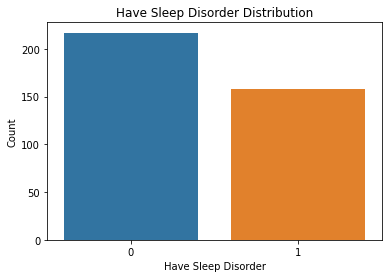

In [43]:
# Construct new column according to presence of sleep disorder values (sleep apnea and insomnia)
df_1_imp = df_1_imp.withColumn(
    "Have_Sleep_Disorder",
    when((col("Sleep Disorder") == "Insomnia") | (col("Sleep Disorder") == "Sleep Apnea"), 1)
    .otherwise(0)
)
sns.countplot(data=df_1_imp.toPandas(), x='Have_Sleep_Disorder')
# Add titles and labels
plt.title("Have Sleep Disorder Distribution")
plt.xlabel("Have Sleep Disorder")
plt.ylabel("Count")

# Convert to boolean
df_1_imp = df_1_imp.withColumn("Have_Sleep_Disorder", col("Have_Sleep_Disorder").cast(BooleanType()))

In [44]:
# Change Y N values to 1 0 
df_2 = df_2.withColumn(
    "PhoneUse",
    when((col("PhoneUse") == "Y"), 1)
    .otherwise(0)
)
df_2.show()

+---------+-------+--------+------------+---------+
|Person ID|Bedtime|PhoneUse|WearsGlasses|Religious|
+---------+-------+--------+------------+---------+
|        1|   1:00|       1|           Y|        Y|
|        2|   0:30|       0|           N|        Y|
|        3|   1:00|       1|           N|        Y|
|        4|   1:00|       1|           N|        Y|
|        5|   1:40|       1|           N|        Y|
|        6|   3:00|       1|           N|        Y|
|        7|   0:50|       1|           Y|        Y|
|        8|   2:50|       0|           N|        N|
|        9|   1:30|       1|           Y|        Y|
|       10|   3:30|       0|           Y|        Y|
|       11|   4:30|       0|           Y|        Y|
|       12|   3:00|       0|           Y|        N|
|       13|   2:00|       1|           N|        N|
|       14|   0:50|       1|           Y|        Y|
|       15|   3:00|       1|           N|        Y|
|       16|   2:20|       1|           Y|        Y|
|       17| 

In [45]:
# Do the same for the other boolean columns
df_2 = df_2.withColumn(
    "WearsGlasses",
    when((col("WearsGlasses") == "Y"), 1)
    .otherwise(0)
)
df_2 = df_2.withColumn(
    "Religious",
    when((col("Religious") == "Y"), 1)
    .otherwise(0)
)
df_2.show()

+---------+-------+--------+------------+---------+
|Person ID|Bedtime|PhoneUse|WearsGlasses|Religious|
+---------+-------+--------+------------+---------+
|        1|   1:00|       1|           1|        1|
|        2|   0:30|       0|           0|        1|
|        3|   1:00|       1|           0|        1|
|        4|   1:00|       1|           0|        1|
|        5|   1:40|       1|           0|        1|
|        6|   3:00|       1|           0|        1|
|        7|   0:50|       1|           1|        1|
|        8|   2:50|       0|           0|        0|
|        9|   1:30|       1|           1|        1|
|       10|   3:30|       0|           1|        1|
|       11|   4:30|       0|           1|        1|
|       12|   3:00|       0|           1|        0|
|       13|   2:00|       1|           0|        0|
|       14|   0:50|       1|           1|        1|
|       15|   3:00|       1|           0|        1|
|       16|   2:20|       1|           1|        1|
|       17| 

## 3.4 Integrating Data

In [60]:
# Rename column to allow for merge 
df_2 = df_2.withColumnRenamed("Person ID", "PersonID")
# Join and merge the two dfs together
df_merged = df_1_imp.join(df_2, on="PersonID", how="inner")
# Drop it as it is no longer needed
df_merged = df_merged.drop("PersonID")
df_merged.show()



+------+---+--------------------+--------------+----------------+-----------------------+------------+-------------+--------------+----------+-----------+--------------+---------------------+-------------------+-------+--------+------------+---------+
|Gender|Age|          Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level| BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|Quality_of_Sleep_Tier|Have_Sleep_Disorder|Bedtime|PhoneUse|WearsGlasses|Religious|
+------+---+--------------------+--------------+----------------+-----------------------+------------+-------------+--------------+----------+-----------+--------------+---------------------+-------------------+-------+--------+------------+---------+
|  Male| 27|   Software Engineer|           6.1|               4|                     42|           6|   Overweight|        126/83|        77|       5200|          None|                    1|              false|   1:00|       1|           1|   

In [61]:
# Unique blood pressure values
print(df_merged.select("Blood Pressure").distinct().count())


25


In [62]:
# Before count
df_merged.groupBy("BMI Category").count().show()

# Changing Normal Weight to Normal
df_merged = df_merged.withColumn(
    "BMI Category",
    when(col("BMI Category") == "Normal Weight", "Normal")
    .otherwise(col("BMI Category"))
)

# After count
df_merged.groupBy("BMI Category").count().show()


+-------------+-----+
| BMI Category|count|
+-------------+-----+
|Normal Weight|   21|
|   Overweight|  151|
|        Obese|   10|
|       Normal|  192|
+-------------+-----+

+------------+-----+
|BMI Category|count|
+------------+-----+
|  Overweight|  151|
|       Obese|   10|
|      Normal|  213|
+------------+-----+



In [63]:
# Before count
df_merged.groupBy("Gender").count().show()

# Changing M and F naming conventions
df_merged = df_merged.withColumn(
    "Gender",
    when(col("Gender") == "M", "Male")
    .when(col("Gender") == "F", "Female")
    .otherwise(col("Gender"))
)

# After count
df_merged.groupBy("Gender").count().show()

+------+-----+
|Gender|count|
+------+-----+
|     F|    2|
|Female|  183|
|     M|    3|
|  Male|  186|
+------+-----+

+------+-----+
|Gender|count|
+------+-----+
|Female|  185|
|  Male|  189|
+------+-----+

